# AdaBoost元算法
 * 前面已经介绍了五种不同的分类算法，它们各有优缺点。我们自然可以将不同的分类器组合起来，而这种组合结果则被称为集成方法（ensemble method）或者元算法（meta-algorithm）。使用集成方法时会有多种形式：可以是不同算法的集成，也可以是同一算法在不同设置下的集成，还可以是数据集不同部分分配给不同分类器之后的集成。接下来，我们将介绍基于同一种分类器多个不同实例的两种计算方法。在这些方法当中，数据集也会不断变化，而后应用于不同的实例分类器上。最后，我们会讨论如何利用机器学习问题的通用框架来应用AdaBoost算法。
   * bagging：基于数据随机重抽样的分类器构建方法
   * boosting

__集成方法通过组合多个分类器的分类结果，获得了比简单的单分类器更好的分类结果。有一些利用不同分类器的集成方法，但是本章只介绍了那些利用同一类分类器的集成方法。__

多个分类器组合可能会进一步凸显出单分类器的不足，__比如过拟合问题。如果分类器之间差别显著，那么多个分类器组合就可能会缓解这一问题__。分类器之间的差别可以是算法本身或者是应用于算法上的数据的不同。

## 基于单层决策树（decision stump，也称决策树桩）构建弱分类器

In [1]:
from numpy import *

In [42]:
def loadSimpData():
    datMat = matrix([[1., 2.1],
                    [2., 1.1],
                    [1.3, 1.],
                    [1., 1.],
                    [2., 1.]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat, classLabels

In [43]:
datMat, classLabels = loadSimpData()

### 单层决策树生成函数

In [45]:
# 用于测试是否有某个值小于或者大于我们正在测试的阈值
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    retArray = ones((shape(dataMatrix)[0], 1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray
# 在一个加权数据集中循环，并找到具有最低错误率的单层决策树
def buildStump(dataArr, classLabels, D):
    dataMatrix = mat(dataArr)
    labelMat = mat(classLabels).T
    m, n = shape(dataMatrix)
    numSteps = 10.0
    bestStump = {}
    bestClassEst = mat(zeros((m, 1)))
    minError = inf
    for i in range(n):
        rangeMin = dataMatrix[:, i].min()
        rangeMax = dataMatrix[:, i].max()
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1, int(numSteps) + 1):
            for inequal in ['lt', 'gt']:
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = \
                        stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = mat(ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                # 计算加权错误率
                weightedError = D.T*errArr
#                 print 'split: dim %d, thresh %.2f, thresh ineqal: \ 
#                        %s, the weighted error is %.3f' % (i, threshVal, inequal, weightedError)
                if weightedError < minError:
                    minError = weightedError
                    bestClassEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClassEst

# 官方文档
# def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#just classify the data
#     retArray = ones((shape(dataMatrix)[0],1))
#     if threshIneq == 'lt':
#         retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
#     else:
#         retArray[dataMatrix[:,dimen] > threshVal] = -1.0
#     return retArray
    

# def buildStump(dataArr,classLabels,D):
#     dataMatrix = mat(dataArr); labelMat = mat(classLabels).T
#     m,n = shape(dataMatrix)
#     numSteps = 10.0; bestStump = {}; bestClasEst = mat(zeros((m,1)))
#     minError = inf #init error sum, to +infinity
#     for i in range(n):#loop over all dimensions
#         rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();
#         stepSize = (rangeMax-rangeMin)/numSteps
#         for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
#             for inequal in ['lt', 'gt']: #go over less than and greater than
#                 threshVal = (rangeMin + float(j) * stepSize)
#                 predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)#call stump classify with i, j, lessThan
#                 errArr = mat(ones((m,1)))
#                 errArr[predictedVals == labelMat] = 0
#                 weightedError = D.T*errArr  #calc total error multiplied by D
#                 #print "split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError)
#                 if weightedError < minError:
#                     minError = weightedError
#                     bestClasEst = predictedVals.copy()
#                     bestStump['dim'] = i
#                     bestStump['thresh'] = threshVal
#                     bestStump['ineq'] = inequal
#     return bestStump,minError,bestClasEst

In [9]:
D = mat(ones((5, 1))/5)
buildStump(dataMat, classLabels, D)

({'dim': 0, 'ineq': 'lt', 'thresh': 1.3}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

## 完整 AdaBoost 算法的实现

In [72]:
# 基于单层决策树的AdaBoost训练过程
def adaBoostTrainDS(dataArr, classLabels, numIt = 40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m, 1))/m)
    aggClassEst = mat(zeros((m, 1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
        # print 'D:', D.T
        alpha = float(0.5*log((1.0-error)/max(error, 1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        # print 'classEst: ',classEst.T
        # 为下一次迭代计算D
        expon = multiply(-1*alpha*mat(classLabels).T, classEst)
        D = multiply(D, exp(expon))
        D = D/D.sum()
        # 错误率累加计算
        aggClassEst += alpha*classEst
        # print 'aggClassEst: ',aggClassEst.T
        aggErrors = multiply(sign(aggClassEst) != 
                            mat(classLabels).T, ones((m, 1)))
        errorRate = aggErrors.sum()/m
        print 'total error:',errorRate, '\n'
        if errorRate == 0.0:
            break
#     return weakClassArr
    return weakClassArr, aggClassEst

###官方的文档
# def adaBoostTrainDS(dataArr,classLabels,numIt=40):
#     weakClassArr = []
#     m = shape(dataArr)[0]
#     D = mat(ones((m,1))/m)   #init D to all equal
#     aggClassEst = mat(zeros((m,1)))
#     for i in range(numIt):
#         bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
#         # print "D:",D.T
#         alpha = float(0.5*log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
#         bestStump['alpha'] = alpha  
#         weakClassArr.append(bestStump)                  #store Stump Params in Array
#         # print "classEst: ",classEst.T
#         expon = multiply(-1*alpha*mat(classLabels).T,classEst) #exponent for D calc, getting messy
#         D = multiply(D,exp(expon))                              #Calc New D for next iteration
#         D = D/D.sum()
#         #calc training error of all classifiers, if this is 0 quit for loop early (use break)
#         aggClassEst += alpha*classEst
#         # print "aggClassEst: ",aggClassEst.T
#         aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T,ones((m,1)))
#         errorRate = aggErrors.sum()/m
#         print "total error: ",errorRate
#         if errorRate == 0.0: break
#     return weakClassArr

In [47]:
classifierArray = adaBoostTrainDS(datMat, classLabels, 9)

D: [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error: 0.2 

D: [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error: 0.2 

D: [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error: 0.0 



In [48]:
classifierArray

[{'alpha': 0.6931471805599453, 'dim': 0, 'ineq': 'lt', 'thresh': 1.3},
 {'alpha': 0.9729550745276565, 'dim': 1, 'ineq': 'lt', 'thresh': 1.0},
 {'alpha': 0.8958797346140273, 'dim': 0, 'ineq': 'lt', 'thresh': 0.9}]

## 测试算法：基于 AdaBoost 的分类

In [51]:
# 每个弱分类器的结果以其对应的alpha值作为权重。所有这些弱分类器的结果加权求和就得到了最后的结果。
def adaClassify(datToClass, classifierArr):
    dataMatrix = mat(datToClass)
    m = shape(dataMatrix)[0]
    aggClassEst = mat(zeros((m, 1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'],\
                                classifierArr[i]['thresh'],\
                                classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha']*classEst
        print aggClassEst
    return sign(aggClassEst)

In [52]:
datArr, labelArr = loadSimpData()
classifierArr = adaBoostTrainDS(datArr, labelArr, 30)

adaClassify([0, 0], classifierArr)

D: [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error: 0.2 

D: [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error: 0.2 

D: [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error: 0.0 

[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]


matrix([[-1.]])

In [53]:
adaClassify([[5, 5], [0, 0]], classifierArr)

[[ 0.69314718]
 [-0.69314718]]
[[ 1.66610226]
 [-1.66610226]]
[[ 2.56198199]
 [-2.56198199]]


matrix([[ 1.],
        [-1.]])

## 示例：在一个难数据集上应用 AdaBoost

In [56]:
# 自适应数据加载函数
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

In [57]:
datArr, labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray = adaBoostTrainDS(datArr, labelArr, 10)

D: [[0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448

D: [[0.00233645 0.00588235 0.00233645 0.00588235 0.00588235 0.00233645
  0.00233645 0.00588235 0.00233645 0.00588235 0.00233645 0.00233645
  0.00233645 0.00588235 0.00233645 0.00233645 0.00233645 0.00233645
  0.00233645 0.00233645 0.00588235 0.00233645 0.00233645 0.00233645
  0.00233645 0.00233645 0.00233645 0.00233645 0.00588235 0.00233645
  0.00233645 0.00588235 0.00233645 0.00233645 0.00588235 0.00233645
  0.00588235 0.00588235 0.00233645 0.00588235 0.00233645 0.00233645
  0.00233645 0.00233645 0.00233645 0.00233645 0.00588235 0.00233645
  0.00588235 0.00233645 0.00233645 0.00588235 0.00233645 0.00233645
  0.00588235 0.00588235 0.00233645 0.00233645 0.00233645 0.00233645
  0.00233645 0.00233645 0.00588235 0.00588235 0.00233645 0.00233645
  0.00233645 0.00233645 0.00233645 0.00233645 0.00588235 0.00233645
  0.00588235 0.00233645 0.00588235 0.00588235 0.00233645 0.00233645
  0.00233645 0.00233645 0.00233645 0.00233645 0.00233645 0.00233645
  0.00233645 0.00233645 0.00233645 0.00588235

classEst:  [[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1. -1. -1.  1.
  -1. -1. -1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1. -1.
  -1.  1.  1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1.
   1. -1.  1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1.
   1. -1.  1. -1.  1.  1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1.  1.
   1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1. -1. -1. -1. -1.
  -1. -1. -1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1. -1.  1. -1. -1.  1.
  -1.  1. -1.  1.  1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1.
  -1. -1. -1. -1.  1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1.  1.  1.  1.
  -1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.
   1. -1. -1. -1. -1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1.  1.  1.
  -1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1. -1. -1. -1. -1.  1.  1.  1.
   1. -1. -1.  1.  1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1.  1. -1. -1.
  -1.  1. -1. -1.  1. -1. -

In [58]:
testArr, testLabelArr = loadDataSet('horseColicTest2.txt')
prediction10 = adaClassify(testArr, classifierArray)


[[ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166

In [59]:
# To get the number of misclassified examples type in:
errArr = mat(ones((67, 1)))
errArr[prediction10 != mat(testLabelArr).T].sum()

16.0

### 错误率指的是在所有测试样例中错分的样例比例
 * 到现在为止，本书都是基于错误率来衡量分类器任务的成功程度的

### 混淆矩阵（confusion matrix）
 * 有这样一个关于在房子周围可能发现的动物类型的预测，这个预测的__三类问题__的混淆矩阵如表7-2所示
 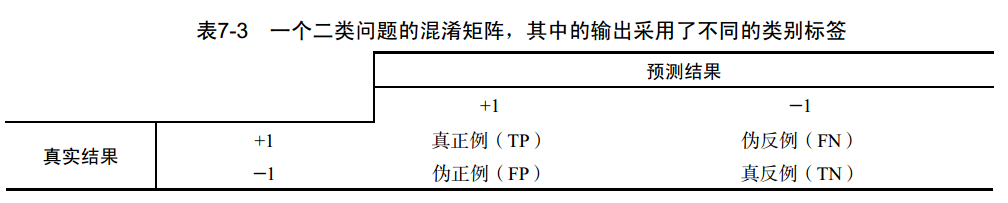
 * 在__二类问题__中，如表7-3中，给出了该混淆矩阵
 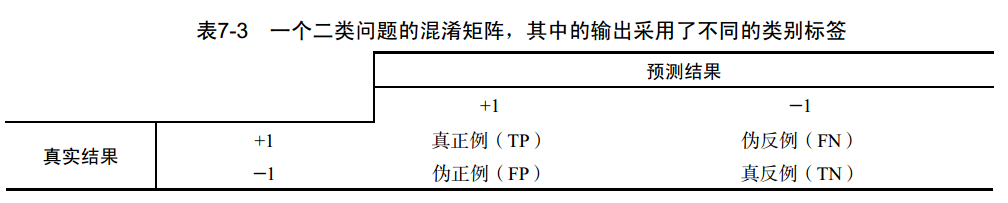
 * 如果将一个正例判为正例，那么就可以认为产生了一个真正例（True Positive， TP，也称真阳）；
 * 如果对一个反例正确地判为反例，则认为产生了一个真反例（True Negative， TN，也称真阴）。
 * 相应地，另外两种情况则分别称为伪反例（False Negative，FN，也称假阴）和伪正例（False Positive， FP，也称假阳）

#### 正确率（Precision）
 * __它等于TP/(TP+FP)，给出的是预测为正例的样本中的真正正例的比例__

#### 召回率（Recall）
 * __它等于TP/(TP+FN)，给出的是预测为正例的真实正例占所有真实正例的比例__

#### 假阳率=FP/(FP+TN)

#### 真阳率=TP/(TP+FN)

### ROC
 * ROC代表接收者操作特征（receiver operating characteristic）
 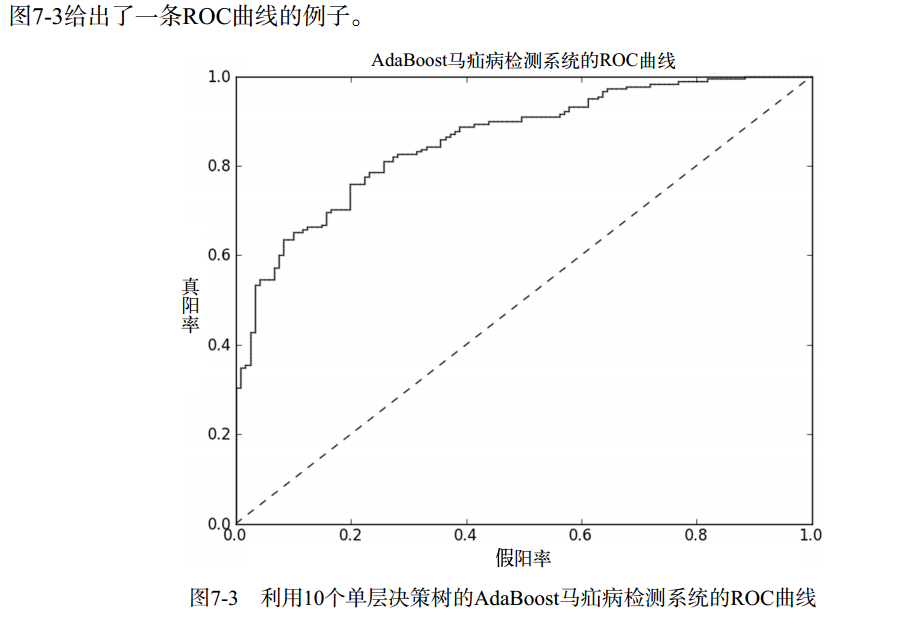
 * ROC曲线给出的是当阈值变化时假阳率和真阳率的变化情况。左下角的点所对应的是将所有样例判为反例的情况，而右上角的点对应的则是将所有样例判为正例的情况。虚线给出的是随机猜测的结果曲线。
 * 曲线下的面积（Area Unser the Curve， AUC）
     * 对不同的ROC曲线进行比较的一个指标；
     * AUC给出的是分类器的平均性能值，当然它并不能完全代替对整条曲线的观察；
     * 一个完美分类器的AUC为1.0，而随机猜测的AUC则为0.5。

In [69]:
# # ROC曲线的绘制及AUC计算函数
# def plotROC(predStrengths, classLabels):
#     import matplotlib.pyplot as plt
#     cur = (1.0, 1.0)
#     ySum = 0.0
#     numPosClas = sum(array(classLabels) == 1.0)
#     yStep = 1/float(numPosClas)
#     xStep = 1/float(len(classLabels) - numPosClas)
#     # 获取排好序的索引
#     sortedIndicies = predStrengths.argsort()
#     fig = plt.figure()
#     fig.clf()
#     ax = plt.subplot(111)
#     for index in sortedIndicies.tolist()[0]:
#         if classLabels[index] == 1.0:
#             delX = 0
#             delY = yStep
#         else:
#             delX = xStep
#             delY = 0
#             ySum += cur[1]
#         ax.plot([cur[0], cur[0]-delX], [cur[1], cur[1]-delY], c='b')
#         cur = (cur[0]-delX, cur[1]-delY)
#     ax.plot([0, 1], [0, 1], 'b--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC cure for AdaBoost Horse Colic Detection System')
#     ax.axis([0, 1, 0, 1])
#     plt.show()
#     print 'the Area Under the Curve is:', ySum*xStep

def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    cur = (1.0,1.0) #cursor
    ySum = 0.0 #variable to calculate AUC
    numPosClas = sum(array(classLabels)==1.0)
    yStep = 1/float(numPosClas); xStep = 1/float(len(classLabels)-numPosClas)
    sortedIndicies = predStrengths.argsort()#get sorted index, it's reverse
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    #loop through all the values, drawing a line segment at each point
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep;
        else:
            delX = xStep; delY = 0;
            ySum += cur[1]
        #draw line from cur to (cur[0]-delX,cur[1]-delY)
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print "the Area Under the Curve is: ",ySum*xStep

In [73]:
datArr, labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray, aggClassEst = adaBoostTrainDS(datArr, labelArr, 10)

total error: 0.2842809364548495 

total error: 0.2842809364548495 

total error: 0.24749163879598662 

total error: 0.24749163879598662 

total error: 0.25418060200668896 

total error: 0.2408026755852843 

total error: 0.2408026755852843 

total error: 0.22073578595317725 

total error: 0.24749163879598662 

total error: 0.23076923076923078 



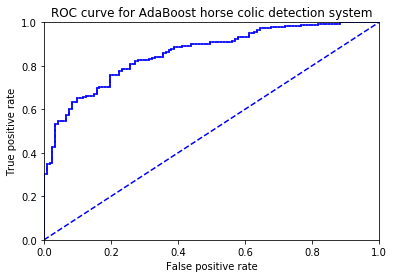

the Area Under the Curve is:  0.858296963506


In [71]:
plotROC(aggClassEst.T, labelArr)

### 基于代价函数的分类器决策控制

#### 代价敏感的学习（cost-sensitive learning）
 * 表7-4中的代价矩阵，
 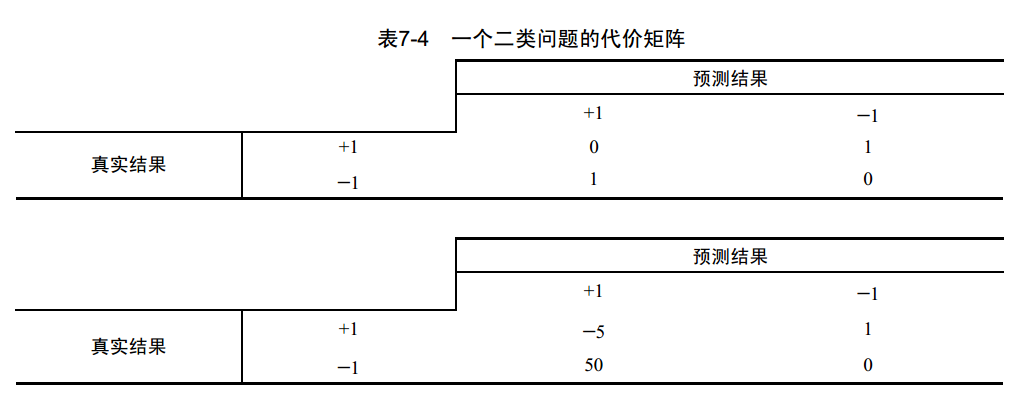
 * 第一张表给出的是到目前为止分类器的代价矩阵（代价不是0就是1）。我们可以基于该代价矩阵计算其总代价：TP*0+FN*1+FP*1+TN*0。
 * 第二张表，基于该代价矩阵的分类代价的计算公式为： TP*(-5)+FN*1+FP*50+TN*0。
 * 采用第二张表作为代价矩阵时，两种分类错误的代价是不一样的。类似地，这两种正确分类所得到的收益也不一样。如果在构建分类器时，知道了这些代价值，那么就可以选择付出最小代价的分类器
 * 在分类算法中，我们有很多方法可以用来引入代价信息。
     * 在AdaBoost中，可以基于代价函数来调整错误权重向量D。
     * 在朴素贝叶斯中，可以选择具有最小期望代价而不是最大概率的类别作为最后的结果。
     * 在SVM中，可以在代价函数中对于不同的类别选择不同的参数C。
     __上述做法就会给较小类更多的权重，即在训练时，小类当中只允许更少的错误。__

### 处理非均衡问题的数据抽样方法
 * 针对非均衡问题调节分类器的方法，就是对分类器的训练数据进行改造
 * 指在分类器训练时正例数目和反例数目不相等（相差很大）
 * 该问题在错分正例和反例的代价不同时也存在

#### 欠抽样（undersampling）
 * 意味着复制样例

#### 过抽样（oversampling）
 * 意味着删除样例